# BERT with Sentiment analysis
In this notebook I used a pretrained version of BERT avaliable as a huggingface transformed to classify the sentiment of news articles about Bitcoin and Tesla, and applied an LSTM to predict the stock returns

In [8]:
from google.colab import drive
drive.mount('/content/drive/')
#change this path to the shared folder dir
# root_folder0="/content/drive/My Drive/Maestría/Sapienza/Semester 3/Data_Mining/Data_Mining_Final_Project"
# root_folder0="/content/drive/My Drive/Trading/Repos/myOwn/Sentiment_Bert_StockMarkets"
root_folder0="/content/drive/My Drive/Maestría/Sapienza/Semester 3/Data_Mining/Data_Mining_Final_Project"
# DB_path_basic="Db/DataSet_basic_all_tickers.csv"
# DB_path="Db/DataSet_all_tickers.csv"
%cd $root_folder0
!pwd
!ls
#flat to decide if isntalll or not the libraries
install_libraries=False

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Maestría/Sapienza/Semester 3/Data_Mining/Data_Mining_Final_Project
/content/drive/My Drive/Maestría/Sapienza/Semester 3/Data_Mining/Data_Mining_Final_Project
Db			   no_Data
images			   Papers
loading_data_tes.py	   PCA_and_Granger_causality_test.ipynb
LSTM_attamp_1.ipynb	   ProjectFinalPresentaion.pptx
LSTM_Extended.ipynb	   technical_indicators2.ipynb
LSTM_FABIAN.ipynb	   technical_indicators.ipynb
LSTM_Filtered.ipynb	   Tesla-sentiment_v2_final.ipynb
mean_causation_matrix.csv  utils.py
Models


In [9]:
def install_libraries_fun():
  !pip install news-please
  !pip install yfinance
  !pip install googlesearch
  !pip install cchardet
  !pip install pandas
  !pip install matplotlib
  !pip install bert-for-tf2
  !pip install transformers
  !pip install stockstats
  
#flat to decide if isntalll or not the libraries
install_libraries=False

if install_libraries:
  install_libraries_fun()

ERROR: Could not find a version that satisfies the requirement googlesearch (from versions: none)
ERROR: No matching distribution found for googlesearch


In [63]:
try: 
  import tensorflow as tf
  import pandas as pd, numpy as np
  from matplotlib import pyplot as plt
  from utils import *
  import importlib
  import utils
  importlib.reload(utils)
  # from utils import *
  import yfinance as yf
  import nltk
  nltk.download('punkt')
  import nltk.data
  from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
  from tensorflow.keras.layers import LSTM, Dense, Input, Flatten
  from tensorflow.keras.layers import TimeDistributed, Dropout, BatchNormalization, MaxPooling1D
  from tensorflow.keras.models import Sequential
  from stockstats import StockDataFrame
  from datetime import date,datetime
  from newsplease import NewsPlease
  from googlesearch import search, get_tbs
  
except :
  print("error")
  install_libraries=True
  install_libraries_fun()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [67]:
#search on internet for new news about a given company
#interval to train and evaluate
start = "2021-01-01"
end   = "2021-02-18"

#keys for scraping
stocks = ["TSLA"]
keywords = {"TSLA": ["tesla", "Elon Musk"]}
generate_dataset_bert=False


In [65]:
#function to search news
def searching_news(search_term, n_articles, start, end = None):
    start_date = datetime.strptime(start, "%Y-%m-%d")
    end_date = start_date if end is None else datetime.strptime(end, "%Y-%m-%d")
    tbs = get_tbs(start_date,end_date)
    number=10
    # urls = find_urls(search_term, tbs, 10)

    results =  search(search_term ,lang = "en",tbs = tbs, country = "usa", tpe = "nws", stop=number)
    urls = []
    for url in results:
        urls.append(url)

    valid_articles = []
    while (len(valid_articles) < n_articles and len(urls) > 0):
        articles_left = 5 - len(valid_articles)
        articles = NewsPlease.from_urls(urls[:articles_left])
        # empty, articles = detect_empty_articles(articles)

        empty = []
        for url in articles:
            article = articles.get(url)
            if (article.maintext == None and article.text == None):
                empty.append(url)
        for k in empty:
            articles.pop(k)

        for new in articles:
            valid_articles.append(articles.get(new))
        urls = urls[articles_left:]
    #print("valid_articles", len(valid_articles))
    return {"search_term": search_term ,"start": start, "end": start if end is None else end,"articles" : valid_articles}

    

In [66]:
if generate_dataset_bert:
  for k in keywords:
    search_term = " | ".join(keywords.get(k))
    dates = pd.date_range(start, end).format(formatter=lambda x: x.strftime('%Y-%m-%d'))
    all_entries = []
    errors = []
    for date in dates:
        try:
            #searching news
            articles_dict = searching_news(search_term, 5, date)
            
            entries = []
            articles, search_term, start = articles_dict["articles"], articles_dict["search_term"], articles_dict["start"]
            for art in articles:
                text = art.maintext if art.maintext != None else art.text
                entry = {
                    "date_google" : start,
                    "date_article": art.date_publish.strftime("%Y-%m-%d") if art.date_publish is not None else None,
                    "search_term" : search_term,
                    "authors" : ",".join(art.authors) if art.authors is not None else None,
                    "source_domain" : art.source_domain,
                    "title" : art.title,
                    "description" : art.description,
                    "url" : art.url,
                    "maintext" : text
                }
                entries.append(entry)

            all_entries.extend(entries)
        except Exception as ex:
            print(ex)
            errors.append({"search_term" : search_term, "date" : date})
            
    df = pd.DataFrame(all_entries)
    errors = pd.DataFrame(errors)
    
    df.to_csv("Db/tesla_indicators_bert.csv")

not a 200 response: 404


You must `download()` an article first!


In [12]:

# stock = StockDataFrame.retype(df_aapl[["Open", "Close", "High", "Low", "Volume"]])
num_years=[1,3,5]
process_DS=False
if process_DS:
  for temp_year in num_years:
    DB_path_years="Db/DataSet_all_tickers_"+str(temp_year)+"_years.csv"
    # DB_path_basic
    df1= pd.read_csv(DB_path_basic, sep='\t',header=[0,1], index_col=0)
    df1.index = pd.to_datetime(df1.index)
    value_to_check = pd.Timestamp(date.today().year-temp_year-1,1,1)
    df1=df1[df1.index>= value_to_check]
    #deleting rows with null values

    buff_Tickers=[]
    Tickers_DF=pd.DataFrame()
    tickers_names=df1.columns.get_level_values('Symbols').unique()#[:2]
    new_tickers_name=[]
    # print(tickers_names)
    for ticker_name in tickers_names:

      temp_df=df1[ticker_name].dropna()
      if len(temp_df)>=(temp_year*316*0.9):
        temp_pd=Feature_Extraction(df1[ticker_name])
        buff_Tickers.append(temp_pd)
        new_tickers_name.append(ticker_name)
    #concat all tickers dataframes already processed
    
    Tickers_DF=pd.concat(buff_Tickers,keys=pd.Index(new_tickers_name,dtype='object',name='Symbols'),axis=1)
    #pay attention to this because can delete important rows
    Tickers_DF=Tickers_DF.dropna()
    #saving into
    print("saving into: "+DB_path_years)
    Tickers_DF.to_csv(DB_path_years,sep='\t',index=True)
# else:
Tickers_DFs=[]
for temp_year in num_years:
    
    DB_path_years="Db/DataSet_all_tickers_"+str(temp_year)+"_years.csv"
    Tickers_DFs.append( pd.read_csv(DB_path_years, sep='\t',header=[0,1], index_col=0))
print("DataSet Loaded")


DataSet Loaded


In [24]:
#defining variables for only one company
start = "2020-06-01"
end   = "2021-02-12"

stocks = ["TSLA"]
keywords = {"TSLA": ["Tesla", "Elon Musk"]}

prices=Tickers_DFs[0][stocks[0]]["close"]
prices

Date
2019-10-10     48.948002
2019-10-11     49.577999
2019-10-14     51.391998
2019-10-15     51.577999
2019-10-16     51.950001
                 ...    
2021-02-09    849.460022
2021-02-10    804.820007
2021-02-11    811.659973
2021-02-12    816.119995
2021-02-16    796.219971
Name: close, Length: 340, dtype: float64

In [26]:

df = pd.read_csv("Db/tesla_indicators_bert.csv", index_col = 0)
#downloading bert model
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

### Split sentences

In [31]:
# main_text = False

titles = df.title
titles.index = df["date_google"]
descriptions = df.description
descriptions.index = df["date_google"]
text = pd.concat([titles,descriptions]).sort_index().dropna()
split_sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')    
print(text.values[0])

The Natural: Elon Musk’s Non-Traditional Approach To Tesla Advertising


In [32]:
split_sentences = text.apply(split_sentence_tokenizer.tokenize)
split_sentences = split_sentences.groupby(split_sentences.index).sum()
split_sentences = pd.DataFrame(split_sentences)

In [33]:
df_ret = label_transformer(prices.copy(), shift = 1)

split_sentences, df_ret = series_intersection(split_sentences, df_ret)
raw_sentences, raw_labels = generate_data_for_tokenizer(split_sentences,df_ret)

lengths = raw_sentences.apply(lambda x: len(x[0].split()), axis = 1)
sentences = raw_sentences[(lengths > 10) & (lengths < 120)] #filter short and long sentences
labels = raw_labels[(lengths > 10) & (lengths < 120)]


In [34]:
# keywords_bitcoin = ["crypto", "BTC", "bitcoin", "blockchain"]
keys =   ["tesla", "Elon", "Musk", "TSLA"]
# keys = keywords_tesla#keywords_bitcoin if bitcoin else keywords_tesla
text = "".join(text.values).replace(".com","-com").replace(".", "").replace(",", "").replace("\n", " ").replace("-com",".com")
new_tokens = find_new_token_with_custom_keywords(text, keys , 6, [])

New tokens to be added:  ['tesla', "tesla's", 'tesla’s', 'teslaelon', '[…]tesla', 'musktesla']


In [36]:
#downloading bert model
model = TFAutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment", from_pt=True)
tokenizer.add_tokens(new_tokens)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


0

In [38]:
example = "I don't like this Tesla company"
print(tokenizer.tokenize(example))
example_ids = tokenizer.encode(example)
print(example_ids)
output = model.predict([example_ids])
print("    1 star     2 stars    3 stars    4 stars    5 stars")
print(output[0])

['i', 'don', "'", 't', 'like', 'this', 'tesla', 'company']
[101, 151, 11530, 112, 162, 11531, 10372, 51571, 11062, 102]
    1 star     2 stars    3 stars    4 stars    5 stars
[[ 2.9783695   2.3704412   0.68177015 -2.1402621  -3.078016  ]]


In [39]:
encoded_sentences = sentences[0].apply(lambda x : tokenizer.encode(x))
predictions = encoded_sentences.apply(lambda x : model.predict([x])[0])

In [42]:
#to analyse the output and the ranges  we get
avg_predictions = predictions.groupby(predictions.index).apply(np.mean)
avg_predictions_array = np.array([a for a in avg_predictions.values])
shape = avg_predictions_array.shape
avg_predictions = pd.DataFrame(avg_predictions_array.reshape((shape[0], shape[2])), index = avg_predictions.index)
pd.to_pickle(avg_predictions, "sentiment_predictions_tesla_with_tokens")

In [43]:
def r2p(d, start = 100):
    return start * (1 + d).cumprod()
def rolling_window(a, window, step_size):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1 - step_size + 1, window)
    strides = a.strides + (a.strides[-1] * step_size,)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
def window_bert_2nd_dim(a, window):
    shape = (a.shape[0] - window + 1, window, a.shape[1])
    strides = (a.strides[0], a.strides[1]*a.shape[1], a.strides[1])
    #print(shape, strides)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
def lstm_model(n_steps):
    n_features = 5
    model = Sequential()
    model.add(LSTM(100, input_shape = (n_steps, n_features), return_sequences = True))
    model.add(TimeDistributed(Dense(20, activation='elu')))
    model.add(Flatten())
    model.add(Dense(1, activation='elu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    print(model.summary())
    return model

In [44]:
mode = "returns"
shift = 1
df_prices = label_transformer(prices.copy(), shift = shift, mode = mode)
avg_predictions, df_prices = series_intersection(avg_predictions, df_prices)

threshold = "2021-01-01"
X_train = avg_predictions.loc[:threshold]
X_test = avg_predictions.loc[threshold:]
y_train = df_prices.loc[:threshold]
y_test = df_prices.loc[threshold:]

In [45]:
def lstm_own_model(X_train, X_test, y_train, y_test, window, start = 100, epochs = 10):
    
    y_test_orig = y_test.values
    y_train_orig = y_train.values
    
    # if standarize_output:
    #     y_test, y_test_mean, y_test_std = standarize(y_test)
    #     y_train, y_train_mean, y_train_std = standarize(y_train)
    
    X_train_roll = window_bert_2nd_dim(X_train.values, window)
    X_test_roll = window_bert_2nd_dim(X_test.values, window)
    y_train_roll = y_train[window - 1:].values
    y_test_roll = y_test[window - 1:].values
    
    lstm = lstm_model(window)
    history = lstm.fit(X_train_roll,y_train_roll, validation_data=(X_test_roll, y_test_roll), epochs = epochs)
    pred_tr = lstm.predict(X_train_roll)
    pred_te = lstm.predict(X_test_roll)
    
   
    pred_prices_tr = r2p(pred_tr, start)
    pred_prices_te = r2p(pred_te, start)
    real_prices_tr = r2p(y_train_orig, start)
    real_prices_te = r2p(y_test_orig, start)
        
   
    print("TEST DATA")
    plt.plot(real_prices_te)
    plt.plot(pred_prices_te)
    plt.legend(["y_real", "y_pred"])
    plt.show()


    print("TRAIN DATA")
    plt.plot(real_prices_tr)
    plt.plot(pred_prices_tr)
    plt.legend(["y_real", "y_pred"])
    plt.show()

    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["loss", "val_loss"])
    plt.show()
    return lstm, pred_tr, pred_te
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            42400     
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 20)             2020      
_________________________________________________________________
flatten (Flatten)            (None, 140)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 141       
Total params: 44,561
Trainable params: 44,561
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
5/5 [==============================] - 6s 104ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 2/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 3/20
5/5 [==============================] - 

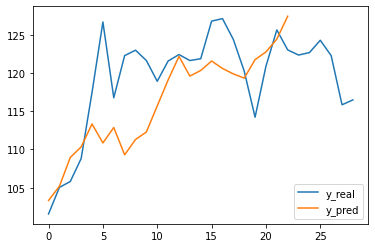

TRAIN DATA


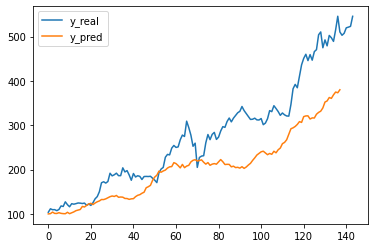

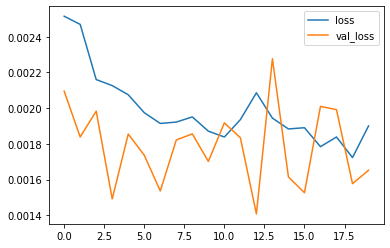

In [46]:
# window 7, 10 epochs, shift = 1
window = 7
# ep = 15

lstm, pred_tr, pred_te = lstm_own_model(X_train, X_test, y_train, y_test, window, 
                                                start = 100, epochs = 20)

